<a href="https://colab.research.google.com/github/xpdlaldam/PyTorch/blob/main/01_pytorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Regression

In [34]:
import torch
from torch import nn ## nn contains all of pytorch's building blocks for nerual networks
import matplotlib.pyplot as plt

torch.__version__

'2.1.0+cu121'

In [35]:
# Create known parameters
weight = .7
bias = .3

# Create data & model
start = 0
end = 1
step = .02

## unsqueeze(dim=1)
# adds 1-D i.e., [ => [[
# we need 2-D for modeling
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
y

tensor([[0.3000],
        [0.3140],
        [0.3280],
        [0.3420],
        [0.3560],
        [0.3700],
        [0.3840],
        [0.3980],
        [0.4120],
        [0.4260],
        [0.4400],
        [0.4540],
        [0.4680],
        [0.4820],
        [0.4960],
        [0.5100],
        [0.5240],
        [0.5380],
        [0.5520],
        [0.5660],
        [0.5800],
        [0.5940],
        [0.6080],
        [0.6220],
        [0.6360],
        [0.6500],
        [0.6640],
        [0.6780],
        [0.6920],
        [0.7060],
        [0.7200],
        [0.7340],
        [0.7480],
        [0.7620],
        [0.7760],
        [0.7900],
        [0.8040],
        [0.8180],
        [0.8320],
        [0.8460],
        [0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

In [36]:
torch.arange(start, end, step)

tensor([0.0000, 0.0200, 0.0400, 0.0600, 0.0800, 0.1000, 0.1200, 0.1400, 0.1600,
        0.1800, 0.2000, 0.2200, 0.2400, 0.2600, 0.2800, 0.3000, 0.3200, 0.3400,
        0.3600, 0.3800, 0.4000, 0.4200, 0.4400, 0.4600, 0.4800, 0.5000, 0.5200,
        0.5400, 0.5600, 0.5800, 0.6000, 0.6200, 0.6400, 0.6600, 0.6800, 0.7000,
        0.7200, 0.7400, 0.7600, 0.7800, 0.8000, 0.8200, 0.8400, 0.8600, 0.8800,
        0.9000, 0.9200, 0.9400, 0.9600, 0.9800])

# Split to train & test

In [37]:
split_ratio = int(.8 * len(X))
X_train, y_train = X[:split_ratio], y[:split_ratio]
X_test, y_test = X[split_ratio:], y[split_ratio:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

# Plot

In [38]:
def plot_pred(
    train_data=X_train,
    train_labels=y_train,
    test_data=X_test,
    test_labels=y_test,
    pred=None,
):
  """
  Plots training & test data and compares against predictions
  """
  plt.figure(figsize=(10, 7))
  plt.scatter(train_data, train_labels, c="b", s=4, label="Train set") # plots train set
  plt.scatter(test_data, test_labels, c="g", s=4, label="Test set") # plots train set

  # are there predictions?
  # if pred: # this checks if pred is True
  if pred is not None: # this checks only the reference pred with None to see if they are the same
    plt.scatter(test_data, pred, c="r", s=4, label="Predictions")

  # legend
  plt.legend(prop={"size": 14})


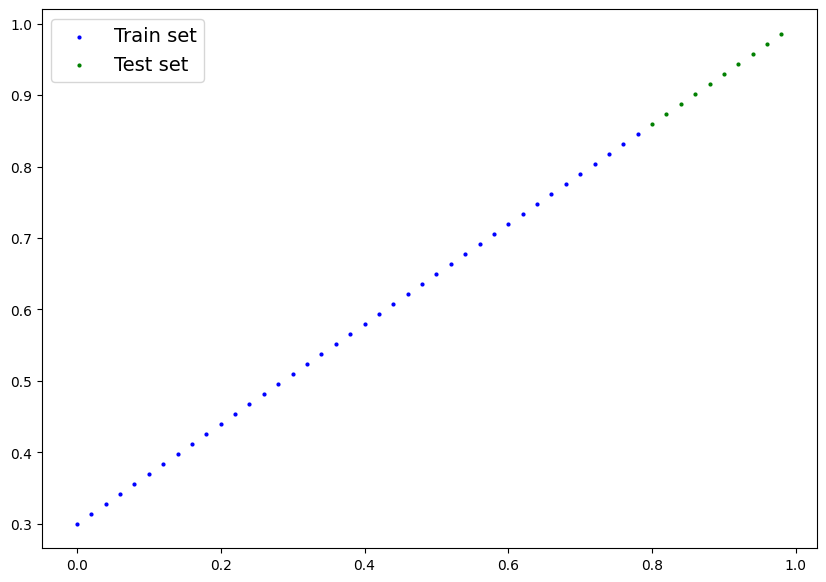

In [39]:
plot_pred()

# Build model

In [40]:
from torch import nn

## nn.Module:
  # almost everything in pytorch inherits nn.module
  # subclasses nn.Module which contains all the building blocks for neural networks
## 1: start with a random weight
## requires_grad=True: can this parameter be updated via gradient descent?
## dtype=torch.float: pytorch loves torch.float32
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()

    ## Initialize model parameters
    self.weights = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float)) # default: float32

    self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

  # Forward
  def forward(self, x: torch.Tensor) -> torch.Tensor: # x is the input data (tensor)
    return self.weights * x + self.bias

# pytorch model building essentials

* torch.nn - contains all the buildings for computational graphs i.e., a neural network
* torch.nn.Parameter - what parameters should our model try and learn, often a pytorch layer from torch.nn will set these for us
* torch.nn.Module - The base class for all neural network modules, if you subclass it, you should override forward()
* torch.optim - this is where optimizers in pytorch lives which helps with gradient descent i.e., instead of random initialization
* def forward() - all nn.Module subclasses require you to override

In [41]:
torch.randn(1)

tensor([0.3367])

In [42]:
torch.manual_seed(42)

lin_reg = LinearRegressionModel()
list(lin_reg.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [43]:
# list named parameters
lin_reg.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

## Predict using `torch.inference_mode()`

In [44]:
X_test

tensor([[0.8000],
        [0.8200],
        [0.8400],
        [0.8600],
        [0.8800],
        [0.9000],
        [0.9200],
        [0.9400],
        [0.9600],
        [0.9800]])

In [45]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

In [46]:
## * CRUCIAL CONCEPT & TIP: Benefits of using a context manager
# Turns off/disables gradient => because we're only doing inference, we don't need to track gradient
# This context manager becomes useful when we have a much larger dataset
# The prediction will be much faster than w/o using a context manager as it disables unnecessary steps used for training
# lin_reg(X_test) leaves the gradient
with torch.inference_mode():
  y_preds = lin_reg(X_test)

# or
# ctrl + /
# with torch.no_grad():
#   y_preds = lin_reg(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

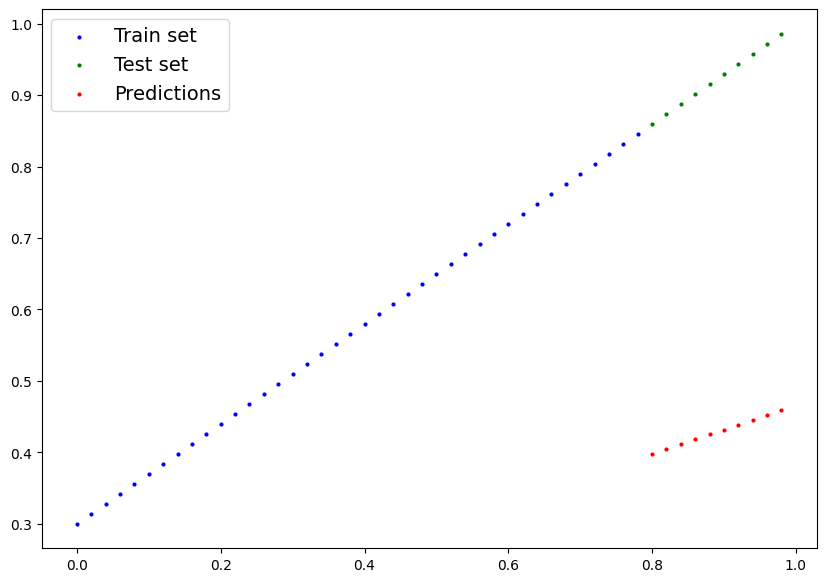

In [47]:
plot_pred(pred=y_preds)

# Train model

* note: loss function = cost function = criterion

Things we need to train:
* **Loss function**:
* **Optimizer**: Takes into account the loss of a model and adjusts the model's parameters (e.g. weight & bias)
* A training loop
* A testing loop

In [48]:
## Setup a loss function
loss_fn = nn.L1Loss() # MAE

## parameter vs hyperparameter
# parameter - the model finds it
# hyperparameter - the data scientists define it

## Setup an optimizer
# params - the model parameters you'd like to optimize
# lr - a hyperparameter that defines the magnitude of change for the optimizer with each step
optimizer = torch.optim.SGD(
    params=lin_reg.parameters(),
    lr=.01
) # SGD

# Build a training loop in pytorch

## What we need in a training loop
0. Loop through the data
1. Forward pass/propagation to make predictions
2. Compute the loss: compare forward pass predictions vs ground truth
3. Optimizer zero grad
4. Loss backward / **backpropagation** - computes the gradients of each of the parameters with respect to the loss
5. Optimizer step / **gradient descent** - adjusts our model's parameters to improve the loss

In [49]:
torch.manual_seed(42)

# An epoch: one loop through the data (a hyperparameter); a single forward pass
epochs = 100

### Train
# 0.
for epoch in range(epochs):
  lin_reg.train() # set the model to training mode which sets all parameters to require gradients

  ## 1. forward pass
  y_pred = lin_reg(X_train)

  ## 2. loss
  loss = loss_fn(y_pred, y_train)
  # print(f"Loss: {loss}")

  ## 3. optimizer zero grad
  # starts fresh
  optimizer.zero_grad()

  ## 4. backpropagation - on the loss with respect to the parameters of the model
  loss.backward()

  ## 5. step the optimizer (perform gradient descent)
  # by default, how the optimizer changes will accumulate
  # through the loop, hence we have to zero them in step 3
  # for the next iteration of the loop
  optimizer.step()

  ### Test
  lin_reg.eval() # turns off different settings in the model not needed for testing (ex) dropout, batch norm layers)
  with torch.inference_mode(): # turns off gradient tracking + a couple more things behind
    # 1. forward pass
    test_pred = lin_reg(X_test)

    # 2. compute the loss
    test_loss = loss_fn(test_pred, y_test)

  if epoch & 10 == 0:
    print(f"Epoch: {epoch} | Test: {loss} | Test loss: {test_loss}")
    print(lin_reg.state_dict())

Loss: 0.31288138031959534
Epoch: 0 | Test: 0.31288138031959534 | Test loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Loss: 0.3013603389263153
Epoch: 1 | Test: 0.3013603389263153 | Test loss: 0.4675942063331604
OrderedDict([('weights', tensor([0.3445])), ('bias', tensor([0.1488]))])
Loss: 0.28983935713768005
Loss: 0.2783183455467224
Loss: 0.26679736375808716
Epoch: 4 | Test: 0.26679736375808716 | Test loss: 0.4271811842918396
OrderedDict([('weights', tensor([0.3562])), ('bias', tensor([0.1788]))])
Loss: 0.2552763521671295
Epoch: 5 | Test: 0.2552763521671295 | Test loss: 0.41371020674705505
OrderedDict([('weights', tensor([0.3601])), ('bias', tensor([0.1888]))])
Loss: 0.24375534057617188
Loss: 0.23223432898521423
Loss: 0.22071333229541779
Loss: 0.20919232070446014
Loss: 0.1976713240146637
Loss: 0.18615034222602844
Loss: 0.1746293306350708
Loss: 0.16310831904411316
Loss: 0.1515873372554779
Loss: 0.14006635546684265
Loss: 0.12854535877704

In [50]:
with torch.inference_mode():
  y_preds_new = lin_reg(X_test)

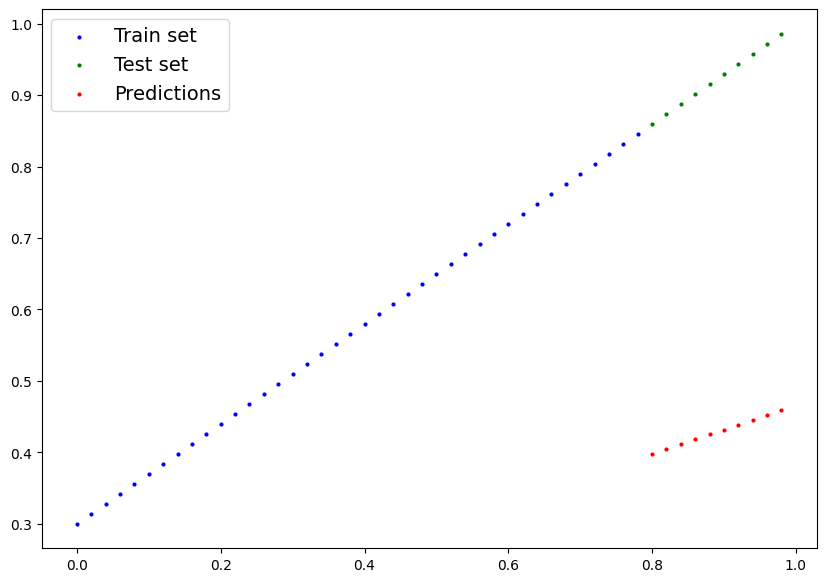

In [51]:
plot_pred(pred=y_preds)

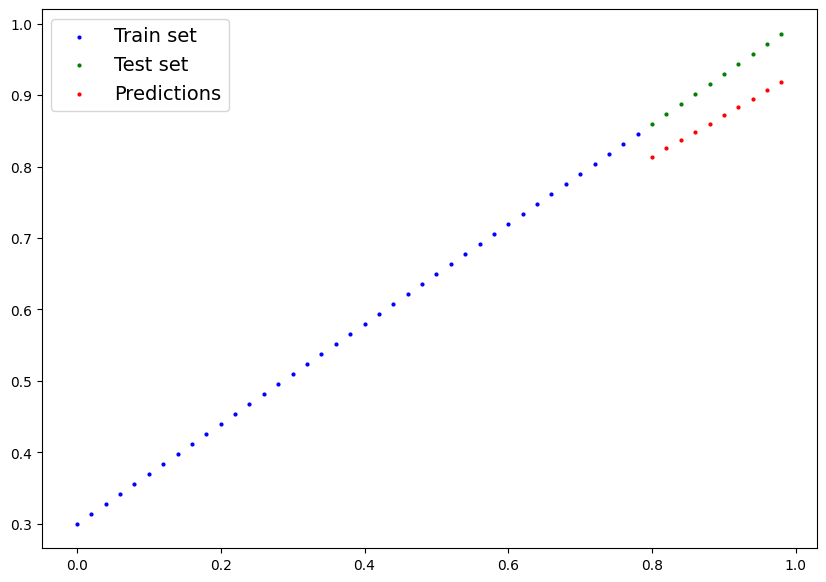

In [52]:
plot_pred(pred=y_preds_new)